In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
from PIL import Image
from sklearn.utils import shuffle
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

Data Exploration

In [ ]:
# download dataset
# reference: https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/
# NOTE: Need to upload kaggle.json file manually if it does not exist in Files (Google Colab)

!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download ashishjangra27/face-mask-12k-images-dataset
!unzip face-mask-12k-images-dataset.zip

In [ ]:
# check how many images and their sizes

# obtain paths
test_mask_path = './Face Mask Dataset/Test/WithMask'
test_nomask_path = './Face Mask Dataset/Test/WithoutMask'
train_mask_path = './Face Mask Dataset/Train/WithMask'
train_nomask_path = './Face Mask Dataset/Train/WithoutMask'
val_mask_path ='./Face Mask Dataset/Validation/WithMask'
val_nomask_path = './Face Mask Dataset/Validation/WithoutMask'

# os.listdir gets all files in a given path
image_count = 0
image_sizes = set()
paths_list = [test_mask_path, test_nomask_path, train_mask_path, train_nomask_path, val_mask_path, val_nomask_path]

#function to add width and height to image_sizes set
#and returns the number of images
def checkImages(path, image_sizes):
  count = 0
  for i in os.listdir(path):
    count += 1
    im = Image.open(os.path.abspath(path + "/" + i))
    width, height = im.size
    image_sizes.add((width, height))
  return count

for path in paths_list:
  image_count += checkImages(path, image_sizes)

print("Total images:", image_count)
print("Image sizes (Width, Height):", image_sizes)

Total images: 11792
Image sizes (Width, Height): {(53, 53), (45, 45), (58, 58), (111, 111), (133, 133), (123, 123), (50, 50), (66, 66), (330, 330), (129, 129), (127, 127), (90, 90), (38, 38), (89, 89), (39, 39), (179, 179), (93, 93), (35, 35), (101, 101), (27, 27), (155, 155), (42, 42), (28, 28), (36, 36), (137, 137), (119, 119), (284, 284), (74, 74), (82, 82), (98, 98), (30, 30), (46, 46), (338, 338), (158, 158), (31, 31), (97, 97), (81, 81), (47, 47), (224, 224), (32, 32), (107, 107), (115, 115), (141, 141), (71, 71), (121, 121), (135, 135), (120, 120), (125, 125), (67, 67), (131, 131), (124, 124), (132, 132), (126, 126), (130, 130), (113, 113), (79, 79), (143, 143), (128, 128), (112, 112), (25, 25), (29, 29), (37, 37), (118, 118), (138, 138), (105, 105), (87, 87), (151, 151), (104, 104), (136, 136), (33, 33), (109, 109), (83, 83), (117, 117), (147, 147), (75, 75), (173, 173), (148, 148), (108, 108), (116, 116), (139, 139), (70, 70), (140, 140), (56, 56), (69, 69), (59, 59), (307, 30

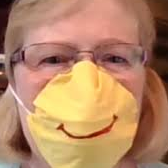

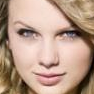

In [ ]:
# view some example images
mask_im = Image.open(os.path.abspath(test_mask_path + "/1174.png"))
nomask_im = Image.open(os.path.abspath(test_nomask_path + "/3006.png"))
display(mask_im)
display(nomask_im)

In [ ]:
# class names
class_names = ['Masked', 'Not masked']
print(class_names)

['Masked', 'Not masked']


In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array

def SetUpData(mask_path):
  mask_list = []
  mask_labels = []
  for i in os.listdir(mask_path):
    im = Image.open(os.path.abspath(mask_path + "/" + i))
    width, height = im.size
    if width >= 100 and height >= 100:
      im = im.resize((100, 100))
      # convert to numpy array
      im = img_to_array(im)
      mask_list.append(im)

      append_label_value = -1
      if 'WithoutMask' in mask_path:
        append_label_value = 0
      else:
        append_label_value = 1
      # -1 means error
      #1 for mask
      #0 for no mask
      mask_labels.append(append_label_value)
  return mask_list, mask_labels


# set up data for training mask data
# establish dataframe containing masked images and their targets
train_mask_df = pd.DataFrame()
train_mask_df['image'], train_mask_df['target'] = SetUpData(train_mask_path)


# set up data for training nonmask data
# establish dataframe containing nonmasked images and their targets
train_nomask_df = pd.DataFrame()
train_nomask_df['image'], train_nomask_df['target'] = SetUpData(train_nomask_path)


# combine separate training dataframes and shuffle
train_df = pd.concat([train_mask_df, train_nomask_df])
train_df = shuffle(train_df)


# set up data for testing mask data
# establish dataframe containing masked images and their targets
test_mask_df = pd.DataFrame()
test_mask_df['image'], test_mask_df['target'] = SetUpData(test_mask_path)


# set up data for testing nomask data
# establish dataframe containing nonmasked images and their targets
test_nomask_df = pd.DataFrame()
test_nomask_df['image'], test_nomask_df['target'] = SetUpData(test_nomask_path)


# combine separate testing dataframes and shuffle
test_df = pd.concat([test_mask_df, test_nomask_df])
test_df = shuffle(test_df)

In [ ]:
train_df

,image,target
3640,"[[[131.0, 168.0, 194.0], [131.0, 168.0, 194.0]...",1
2290,"[[[202.0, 172.0, 175.0], [202.0, 178.0, 182.0]...",0
4370,"[[[255.0, 255.0, 255.0], [255.0, 255.0, 255.0]...",1
1693,"[[[129.0, 111.0, 78.0], [108.0, 91.0, 61.0], [...",0
1829,"[[[77.0, 50.0, 29.0], [76.0, 48.0, 27.0], [75....",1
...,...,...
2010,"[[[100.0, 96.0, 104.0], [101.0, 96.0, 104.0], ...",1
1347,"[[[209.0, 205.0, 193.0], [128.0, 122.0, 108.0]...",0
1262,"[[[171.0, 104.0, 52.0], [170.0, 102.0, 52.0], ...",1
1640,"[[[107.0, 100.0, 89.0], [96.0, 89.0, 76.0], [7...",1


In [ ]:
test_df

,image,target
32,"[[[31.0, 21.0, 11.0], [20.0, 10.0, 1.0], [16.0...",0
104,"[[[55.0, 90.0, 90.0], [2.0, 19.0, 23.0], [8.0,...",1
321,"[[[142.0, 111.0, 67.0], [119.0, 88.0, 44.0], [...",0
40,"[[[136.0, 102.0, 103.0], [137.0, 103.0, 104.0]...",1
385,"[[[32.0, 16.0, 2.0], [36.0, 18.0, 6.0], [43.0,...",1
...,...,...
304,"[[[67.0, 45.0, 25.0], [67.0, 45.0, 25.0], [67....",1
356,"[[[191.0, 192.0, 192.0], [191.0, 192.0, 192.0]...",1
48,"[[[132.0, 114.0, 93.0], [133.0, 115.0, 95.0], ...",1
24,"[[[17.0, 17.0, 17.0], [17.0, 16.0, 16.0], [19....",1


In [ ]:
# creating the model
train_model = Sequential([
  layers.Rescaling(1./255, input_shape=(100, 100, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(1, activation='sigmoid'),
])

In [ ]:
# creating second model
train_model_2 = Sequential([
    layers.Rescaling(1./255, input_shape=(100,100,3)),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(16, activation='relu'),
    layers.Dense(1, activation='softmax')
])

In [ ]:
# compiling the model
train_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
# compiling second model
train_model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
train_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 100, 100, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 64)        1

In [ ]:
train_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 100, 100, 128)     3584      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 50, 50, 32)        36896     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 20000)            

In [ ]:
train_image_array = np.stack(np.asarray(train_df["image"]))
test_image_array = np.stack(np.asarray(test_df["image"]))
train_target_array = np.asarray(train_df["target"])
test_target_array = np.asarray(test_df["target"])

In [ ]:
print(train_image_array.shape)

(8020, 100, 100, 3)


In [ ]:
fitted_Model = train_model.fit(train_image_array, train_target_array, validation_split=0.15, batch_size=10, epochs=10)

Epoch 1/10
682/682 [==============================] - 129s 187ms/step - loss: 0.1309 - accuracy: 0.9514 - val_loss: 0.0356 - val_accuracy: 0.9875
Epoch 2/10
682/682 [==============================] - 114s 167ms/step - loss: 0.0410 - accuracy: 0.9864 - val_loss: 0.0502 - val_accuracy: 0.9817
Epoch 3/10
682/682 [==============================] - 92s 135ms/step - loss: 0.0335 - accuracy: 0.9886 - val_loss: 0.0265 - val_accuracy: 0.9892
Epoch 4/10
682/682 [==============================] - 114s 168ms/step - loss: 0.0300 - accuracy: 0.9902 - val_loss: 0.0582 - val_accuracy: 0.9800
Epoch 5/10
682/682 [==============================] - 87s 128ms/step - loss: 0.0199 - accuracy: 0.9924 - val_loss: 0.0365 - val_accuracy: 0.9859
Epoch 6/10
682/682 [==============================] - 85s 125ms/step - loss: 0.0186 - accuracy: 0.9927 - val_loss: 0.0262 - val_accuracy: 0.9925
Epoch 7/10
682/682 [==============================] - 86s 127ms/step - loss: 0.0171 - accuracy: 0.9934 - val_loss: 0.0357 - val

In [ ]:
fitted_Model_2 = train_model_2.fit(train_image_array, train_target_array, validation_split=0.15, batch_size=10, epochs=10)

Epoch 1/10
682/682 [==============================] - 307s 449ms/step - loss: 0.1836 - accuracy: 0.5502 - val_loss: 0.0622 - val_accuracy: 0.5470
Epoch 2/10
682/682 [==============================] - 306s 448ms/step - loss: 0.0415 - accuracy: 0.5502 - val_loss: 0.0496 - val_accuracy: 0.5470
Epoch 3/10
682/682 [==============================] - 304s 446ms/step - loss: 0.0274 - accuracy: 0.5502 - val_loss: 0.0504 - val_accuracy: 0.5470
Epoch 4/10
682/682 [==============================] - 302s 443ms/step - loss: 0.0322 - accuracy: 0.5502 - val_loss: 0.0617 - val_accuracy: 0.5470
Epoch 5/10
682/682 [==============================] - 303s 444ms/step - loss: 0.0224 - accuracy: 0.5502 - val_loss: 0.0341 - val_accuracy: 0.5470
Epoch 6/10
682/682 [==============================] - 305s 448ms/step - loss: 0.0153 - accuracy: 0.5502 - val_loss: 0.0524 - val_accuracy: 0.5470
Epoch 7/10
682/682 [==============================] - 307s 449ms/step - loss: 0.0115 - accuracy: 0.5502 - val_loss: 0.0278 -

In [ ]:
## evaluate model to compare training vs. test error
from sklearn.metrics import classification_report

yhat_train = train_model.predict(train_image_array)
yhat_train = [1 if y>=0.5 else 0 for y in yhat_train]
yhat_test = train_model.predict(test_image_array)
yhat_test = [1 if y>=0.5 else 0 for y in yhat_test]

yhat_train2 = train_model_2.predict(train_image_array)
yhat_train2 = [1 if y>=0.5 else 0 for y in yhat_train2]
yhat_test2 = train_model_2.predict(test_image_array)
yhat_test2 = [1 if y>=0.5 else 0 for y in yhat_test2]

print("Training performance of Model 1:\n %s" % classification_report(train_target_array, yhat_train))

print("Testing performance of Model 1:\n %s" % classification_report(test_target_array, yhat_test))

print("Training performance of Model 2:\n %s" % classification_report(train_target_array, yhat_train2))

print("Testing performance of Model 2:\n %s" % classification_report(test_target_array, yhat_test2))


25/25 [==============================] - 7s 279ms/step
Training performance of Model 1:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      3611
           1       1.00      1.00      1.00      4409

    accuracy                           1.00      8020
   macro avg       1.00      1.00      1.00      8020
weighted avg       1.00      1.00      1.00      8020

Testing performance of Model 1:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       372
           1       0.99      0.98      0.99       427

    accuracy                           0.98       799
   macro avg       0.98      0.99      0.98       799
weighted avg       0.99      0.98      0.98       799

Training performance of Model 2:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      3611
           1       0.55      1.00      0.71      4409

    accuracy              

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

25/25 [==============================] - 4s 179ms/step - loss: 0.0441 - accuracy: 0.9850


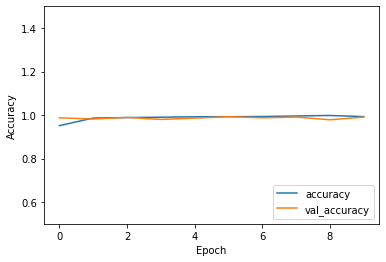

In [ ]:
# Evaluation Graph
import matplotlib.pyplot as plt

plt.plot(fitted_Model.history['accuracy'], label='accuracy')
plt.plot(fitted_Model.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1.5])
plt.legend(loc='lower right')

test_loss, test_acc = train_model.evaluate(test_image_array, test_target_array)

25/25 [==============================] - 7s 282ms/step - loss: 0.0871 - accuracy: 0.5344


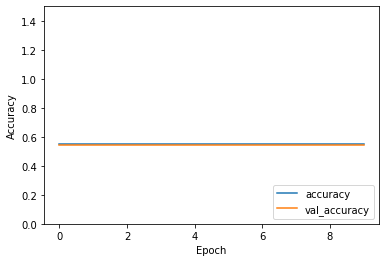

In [ ]:
plt.plot(fitted_Model_2.history['accuracy'], label='accuracy')
plt.plot(fitted_Model_2.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1.5])
plt.legend(loc='lower right')

test_loss, test_acc = train_model_2.evaluate(test_image_array, test_target_array)